In [1]:
import deorbit
import matplotlib.pyplot as plt
import deorbit.data_models
from deorbit.predictor import EKF
from deorbit.utils.dataio import load_sim_data, load_sim_config
import numpy as np
from deorbit.observer import Observer


In [2]:
save_path = "eg/EKF_example_noise/"

sim_data = load_sim_data(save_path)
sim_config = load_sim_config(save_path)

if sim_data is None or sim_config is None:
    sim = deorbit.simulator.run(
        "adams_bashforth",
        "coesa_atmos_fast",
        initial_state=np.array((deorbit.constants.EARTH_RADIUS + 150000, 0, 0, 7820)),
        noise_types = {"gaussian": {"noise_strength": 0.01}, "impulse": {"impulse_strength": 0.1, "impulse_probability": 1e-5}},
        time_step=0.1,
    )
    sim_data = sim.gather_data()
    sim_config = sim.export_config()
    sim.save_data(save_path)
else:
    print("Loaded data from file")

Loaded data from file


In [3]:
obs = Observer(number_of_radars=3)
sim_states = sim_data.state_array()
sim_times = sim_data.times

obs.run(sim_states=sim_states, sim_times=sim_times, checking_interval=100)

observation_times = obs.observed_times
observation_states = obs.observed_states

observations = (observation_states, observation_times)

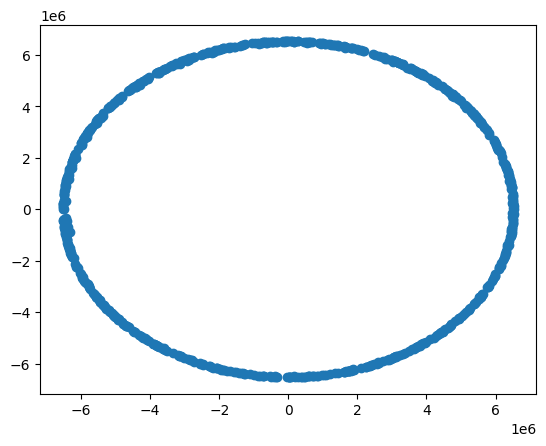

In [4]:
fig, ax = plt.subplots()

ax.scatter(observation_states[:, 0], observation_states[:, 1])
#earth = plt.Circle((0, 0), radius=deorbit.constants.EARTH_RADIUS, fill=False)
#ax.add_patch(earth)
#why when add more radars do you get more radar readings?? -- thought that it just took reading from closest radar??

In [5]:
# Define process and measurement noise covariance matrices, think this noise should be alot bigger
Q = np.diag([0.1, 0.1, 0.01, 0.01])#process noise
R = np.diag([1, 1, 0.1, 0.1]) #measurement noise
P = np.diag([1, 1, 1, 1]) #error covariance matrix - represents uncertainty in state estimation

# Measurement matrix H (assuming all states are measured directly??????) -- for now
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

dt = sim_config.simulation_method_kwargs.time_step

ekf = EKF()

estimated_traj, uncertainties, estimated_times = ekf.run(observations, dt, Q, R, P, H)

  1%|          | 4/754 [00:00<00:19, 37.75it/s]

[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
[[ 5.21175708e+01 -1.46372590e-02  5.79522166e+00 -2.65627254e-02]
 [-1.46372590e-02  5.09098889e+01  2.56525396e-02  5.73824099e+00]
 [ 5.79522166e+00  2.56525396e-02  1.08101854e+00  7.93775668e-05]
 [-2.65627254e-02  5.73824099e+00  7.93775668e-05  1.08094486e+00]]
[[ 5.19567558e+01  2.15064249e-02  5.71898105e+00 -2.31118327e-02]
 [ 2.15064249e-02  5.07870170e+01  2.55791072e-02  5.66482374e+00]
 [ 5.71898105e+00  2.55791072e-02  1.07188926e+00  7.78395923e-05]
 [-2.31118327e-02  5.66482374e+00  7.78395923e-05  1.07174906e+00]]
[[ 5.19264673e+01  1.06989936e-02  5.71851315e+00 -2.34731638e-02]
 [ 1.06989936e-02  5.07828101e+01  2.49884025e-02  5.66554017e+00]
 [ 5.71851315e+00  2.49884025e-02  1.07206689e+00  8.08665279e-05]
 [-2.34731638e-02  5.66554017e+00  8.08665279e-05  1.07192963e+00]]
[[ 5.18636681e+01  7.56330112e-03  5.71564704e+00 -2.24032990e-02]
 [ 7.56330112e-03  5.07893422e+01  2.36696391e-02  5.66585507e+00]
 [ 5.71564704e

  1%|          | 8/754 [00:00<00:23, 31.14it/s]

[[ 5.18623295e+01  1.31501402e-02  5.71552835e+00 -2.36674662e-02]
 [ 1.31501402e-02  5.07421600e+01  2.54254613e-02  5.66369027e+00]
 [ 5.71552835e+00  2.54254613e-02  1.07205189e+00  8.22549705e-05]
 [-2.36674662e-02  5.66369027e+00  8.22549705e-05  1.07193451e+00]]
[[ 5.17896215e+01 -2.90821309e-02  5.71221032e+00 -2.55932866e-02]
 [-2.90821309e-02  5.07000763e+01  2.35026041e-02  5.66176407e+00]
 [ 5.71221032e+00  2.35026041e-02  1.07205101e+00  8.36912707e-05]
 [-2.55932866e-02  5.66176407e+00  8.36912707e-05  1.07193585e+00]]


  2%|▏         | 12/754 [00:01<01:54,  6.49it/s]

[[4.54468417e+08 1.55340654e+08 3.48239974e+07 8.39932519e+06]
 [1.55340654e+08 5.32708532e+07 1.19164318e+07 2.87626704e+06]
 [3.48239974e+07 1.19164318e+07 2.66944390e+06 6.44007876e+05]
 [8.39932519e+06 2.87626704e+06 6.44007876e+05 1.55398216e+05]]
[[ 5.27182097e+01 -2.19377880e-01  5.83142045e+00 -5.68972087e-02]
 [-2.44438097e-01  5.10309714e+01 -7.76172157e-03  5.72325808e+00]
 [ 5.83476224e+00 -5.65786471e-03  1.08712058e+00 -3.97802292e-03]
 [-5.48909689e-02  5.72413014e+00 -3.92591974e-03  1.08112885e+00]]
[[ 5.14210684e+01  5.03339488e-03  5.69500129e+00 -2.30179937e-02]
 [ 4.59028870e-03  5.02242816e+01  2.39252789e-02  5.63997483e+00]
 [ 5.69501205e+00  2.39899923e-02  1.07197129e+00  7.97626415e-05]
 [-2.30697465e-02  5.63997771e+00  7.21343025e-05  1.07198554e+00]]
[[ 5.14207480e+01  3.53903041e-03  5.69492379e+00 -2.39702027e-02]
 [ 3.53787399e-03  5.01611815e+01  2.46924772e-02  5.63697957e+00]
 [ 5.69492383e+00  2.46925811e-02  1.07195483e+00  7.18861122e-05]
 [-2.397

KeyboardInterrupt: 

  2%|▏         | 13/754 [00:19<01:54,  6.49it/s]

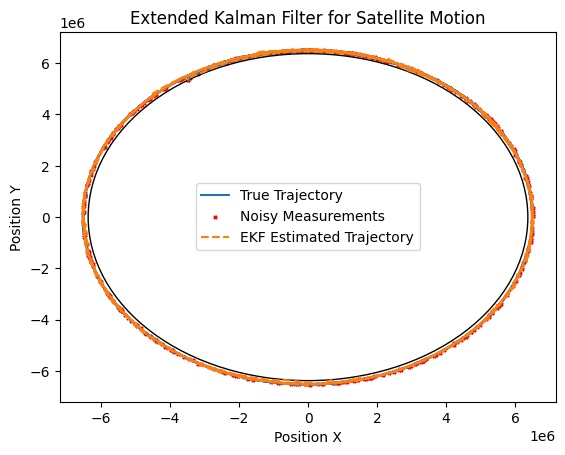

In [ ]:
# %matplotlib widget
true_traj = sim_data.state_array()[:, :2]

crash_coords = true_traj[-1, :]


fig, ax1 = plt.subplots()

plot_range = slice(0, 290925)

ax1.plot(true_traj[:, 0][plot_range], true_traj[:, 1][plot_range], label='True Trajectory')
ax1.scatter(observation_states[:, 0][plot_range], observation_states[:, 1][plot_range], marker='x', color='r', label='Noisy Measurements', s=5)
ax1.plot(estimated_traj[:, 0][plot_range], estimated_traj[:, 1][plot_range], label='EKF Estimated Trajectory', linestyle='--')
ax1.set_title('Extended Kalman Filter for Satellite Motion')
ax1.set_xlabel('Position X')
ax1.set_ylabel('Position Y')
earth = plt.Circle((0, 0), radius=deorbit.constants.EARTH_RADIUS, fill=False)
ax1.add_patch(earth)
ax1.legend()


# ax2.plot(true_traj[:, 0], true_traj[:, 1], label='True Trajectory')
# ax2.scatter(measurements[:, 0], measurements[:, 1], marker='x', color='r', label='Noisy Measurements', s=1)
# ax2.plot(estimated_traj[:, 0], estimated_traj[:, 1], label='EKF Estimated Trajectory', linestyle='--')
# ax2.set_title('Extended Kalman Filter for Satellite Motion')
# ax2.set_xlabel('Position X')
# ax2.set_ylabel('Position Y')
# ax2.set_xlim([crash_coords[0]-4e5, crash_coords[0]+4e5])
# ax2.set_ylim([crash_coords[1]-4e5, crash_coords[1]+4e5])
# earth = plt.Circle((0, 0), radius=deorbit.constants.EARTH_RADIUS, fill=False)
# ax2.add_patch(earth)


plt.show()

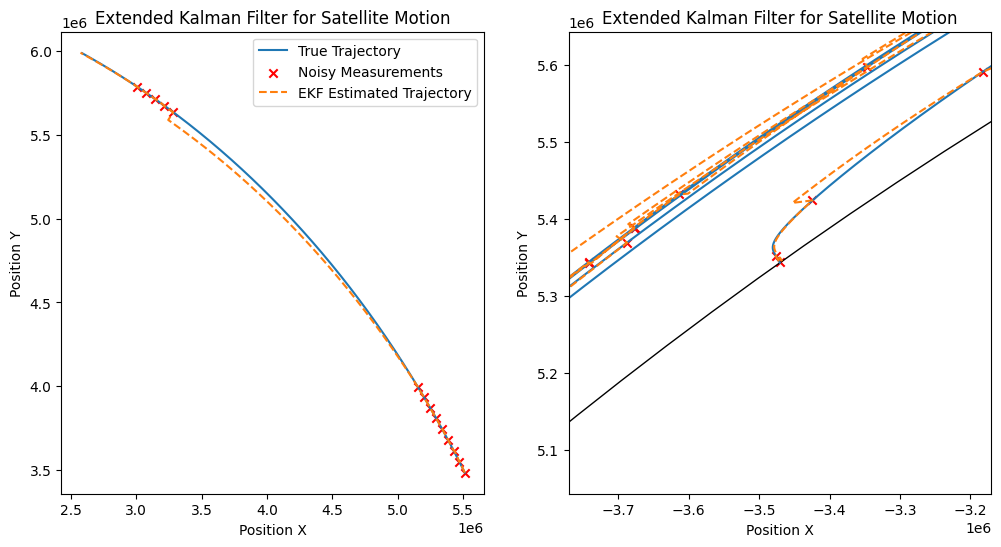

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

plot_duration = 500

start_index = np.argmax(sim_times > observation_times[0])
start_time = sim_times[start_index]
end_time = start_time + plot_duration

true_traj_slice = slice(start_index, int(end_time/dt))
est_traj_slice = slice(0, int(plot_duration/dt))
measure_slice = slice(0, np.argmax(observation_times > end_time))

ax1.plot(true_traj[:, 0][true_traj_slice], true_traj[:, 1][true_traj_slice], label='True Trajectory')
ax1.scatter(observation_states[:, 0][measure_slice], observation_states[:, 1][measure_slice], marker='x', color='r', label='Noisy Measurements')
ax1.plot(estimated_traj[:, 0][est_traj_slice], estimated_traj[:, 1][est_traj_slice], label='EKF Estimated Trajectory', linestyle='--')
ax1.set_title('Extended Kalman Filter for Satellite Motion')
ax1.set_xlabel('Position X')
ax1.set_ylabel('Position Y')



ax2.plot(true_traj[:, 0], true_traj[:, 1], label='True Trajectory')
ax2.scatter(observation_states[:, 0], observation_states[:, 1], marker='x', color='r', label='Noisy Measurements')
ax2.plot(estimated_traj[:, 0], estimated_traj[:, 1], label='EKF Estimated Trajectory', linestyle='--')
ax2.set_title('Extended Kalman Filter for Satellite Motion')
ax2.set_xlabel('Position X')
ax2.set_ylabel('Position Y')
ax2.set_xlim([crash_coords[0]-3e5, crash_coords[0]+3e5])
ax2.set_ylim([crash_coords[1]-3e5, crash_coords[1]+3e5])
earth = plt.Circle((0, 0), radius=deorbit.constants.EARTH_RADIUS, fill=False)
ax2.add_patch(earth)
ax1.legend()

plt.show()